Librerías

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
import matplotlib.ticker as ti
from itertools import islice
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.signal import find_peaks

**Actividad 1**

Importación de datos

In [161]:
df = pd.read_csv("actividad 1.csv", delimiter=';', skiprows=2)
df.dropna(how='any', inplace=True)
df.columns = ["theta_deg", "intensity"]
df["theta_deg"] = df["theta_deg"].str.replace(",", ".").astype(float)
df["intensity"] = df["intensity"].astype(float)
df.head()


,theta_deg,intensity
0,15.0,389.0
1,15.1,384.0
2,15.2,389.0
3,15.3,370.0
4,15.4,387.0


Gráficas

In [162]:
desface_grados = 1.9 #°
desface_radianes = np.deg2rad(desface_grados) #rad
theta = df["theta_deg"].to_numpy() #°
intensity = df["intensity"].to_numpy() #u.a.
theta_rad = np.deg2rad(theta) #rad
theta_rad = theta_rad + desface_radianes #rad

d = 2.04e-10 #m
h = 6.626e-34 #J.s
c = 3e8 #m/s

In [163]:
def lambda_func(theta,n):
    f = 2 * d * np.sin(theta) #m
    return f/n

lambda_l = lambda_func(theta_rad,1) #m
lambda_a = lambda_l * 1e10 #nm
lambda_2 = lambda_func(theta_rad + 0*desface_radianes,2) #m
lambda_b = lambda_2 * 1e10 #nm

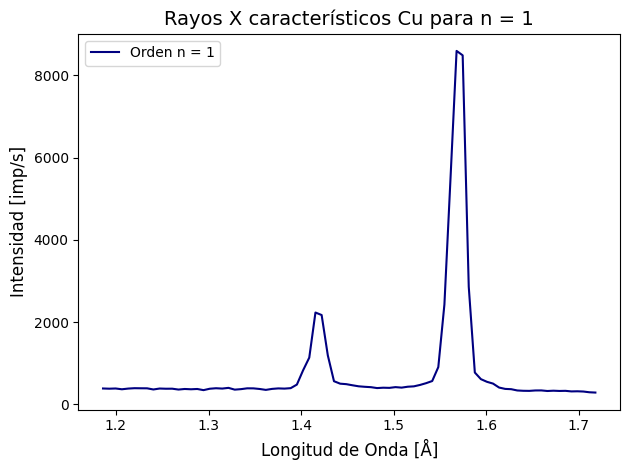

In [164]:
plt.plot(lambda_a, intensity, label='Orden n = 1', color='navy', linewidth=1.5)

plt.xlabel('Longitud de Onda [Å]', fontsize=12)
plt.ylabel('Intensidad [imp/s]', fontsize=12)
plt.title('Rayos X característicos Cu para n = 1', fontsize=14)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [165]:
# Encontrar índices de los picos en la señal de intensidad
peaks_indices, _ = find_peaks(intensity, height=1000)  # Ajusta el umbral 'height' según tu caso

# Obtener las posiciones en el eje X correspondientes a esos picos
peaks_x = lambda_a[peaks_indices]
peaks_y = intensity[peaks_indices]

# Imprimir resultados
for i, (x, y) in enumerate(zip(peaks_x, peaks_y), 1):
    print(f"Pico {i}: λ = {x:.4f} Å, Intensidad = {y:.1f} imp/s")

Pico 1: λ = 1.4155 Å, Intensidad = 2235.0 imp/s
Pico 2: λ = 1.5679 Å, Intensidad = 8592.0 imp/s


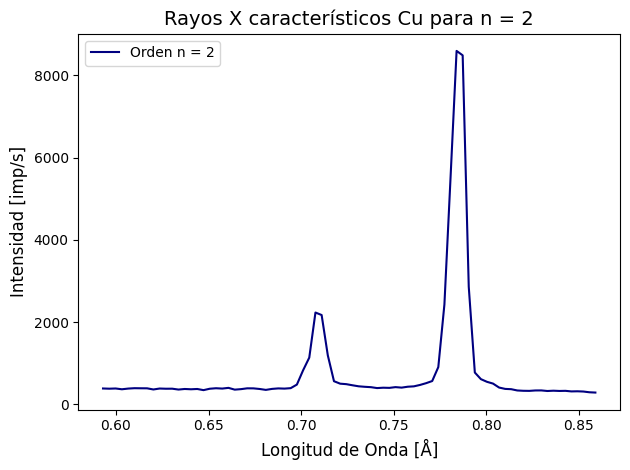

In [166]:
plt.plot(lambda_b, intensity, label='Orden n = 2', color='navy', linewidth=1.5)

plt.xlabel('Longitud de Onda [Å]', fontsize=12)
plt.ylabel('Intensidad [imp/s]', fontsize=12)
plt.title('Rayos X característicos Cu para n = 2', fontsize=14)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [167]:
# Encontrar índices de los picos en la señal de intensidad
peaks_indices, _ = find_peaks(intensity, height=1000)  # Ajusta el umbral 'height' según tu caso

# Obtener las posiciones en el eje X correspondientes a esos picos
peaks_x = lambda_b[peaks_indices]
peaks_y = intensity[peaks_indices]

# Imprimir resultados
for i, (x, y) in enumerate(zip(peaks_x, peaks_y), 1):
    print(f"Pico {i}: λ = {x:.4f} Å, Intensidad = {y:.1f} imp/s")

Pico 1: λ = 0.7077 Å, Intensidad = 2235.0 imp/s
Pico 2: λ = 0.7840 Å, Intensidad = 8592.0 imp/s


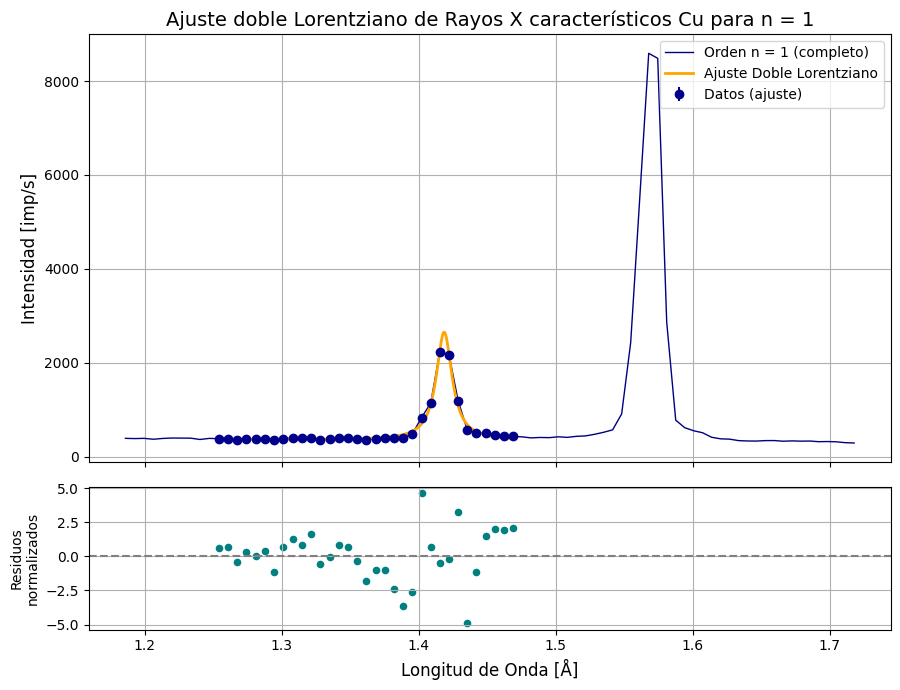

In [168]:
# Ajuste de la curva de Lorentziana
# Función: suma de dos lorentzianas
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

# Ventana que cubre ambos picos
idx_fit = (lambda_a > 1.25) & (lambda_a < 1.47)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, gamma1, A2, x02, gamma2]
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]

# Ajuste con pesos
popt, pcov = curve_fit(double_lorentzian, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=10000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_lorentzian(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_lorentzian(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Lorentziano de Rayos X característicos Cu para n = 1', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()


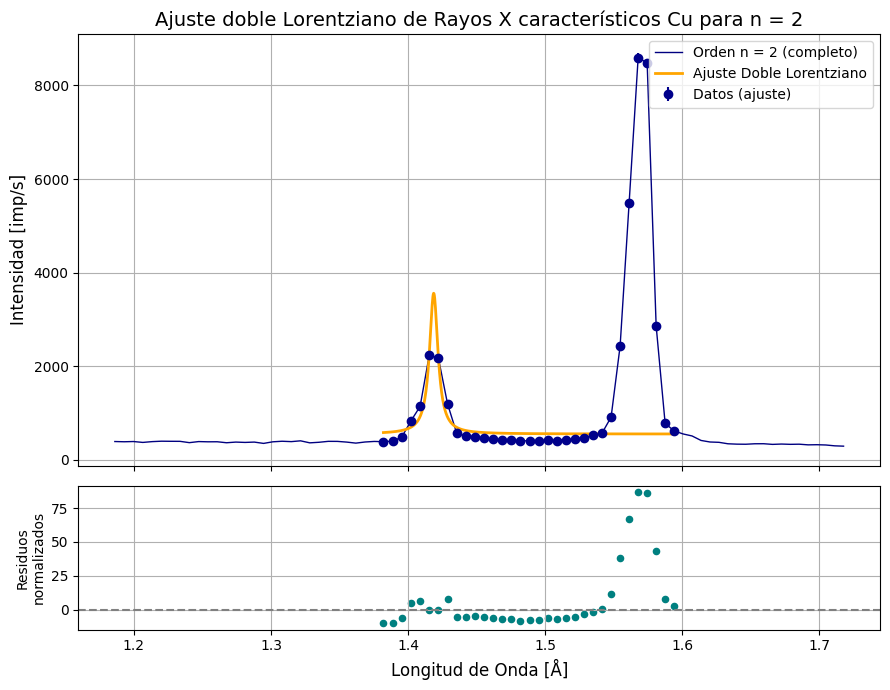

In [169]:
# Ajuste de la curva de Lorentziana
# Función: suma de dos lorentzianas
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

# Ventana que cubre ambos picos
idx_fit = (lambda_b > 0.69) & (lambda_b < 0.8)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, gamma1, A2, x02, gamma2]
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]

# Ajuste con pesos
popt, pcov = curve_fit(double_lorentzian, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=10000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_lorentzian(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_lorentzian(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Lorentziano de Rayos X característicos Cu para n = 2', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()

In [170]:
# Función doble lorentziana
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# ========================= Gráfica para n = 1 =========================
idx_fit1 = (lambda_a > 1.25) & (lambda_a < 1.47)
x1 = lambda_a[idx_fit1]
y1 = intensity[idx_fit1]
errors1 = np.sqrt(y1)
errors1[errors1 == 0] = 1
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]
popt1, pcov1 = curve_fit(double_lorentzian, x1, y1, p0=p0, sigma=errors1, absolute_sigma=True, maxfev=10000)
x_fit1 = np.linspace(min(x1), max(x1), 800)
y_fit1 = double_lorentzian(x_fit1, *popt1)
residuals1 = y1 - double_lorentzian(x1, *popt1)
norm_res1 = residuals1 / errors1

ax1_curve = axes[0, 0]
ax1_resid = axes[1, 0]

ax1_curve.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)
ax1_curve.errorbar(x1, y1, yerr=errors1, fmt='o', color='darkblue', label='Datos (ajuste)')
ax1_curve.plot(x_fit1, y_fit1, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')
ax1_curve.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1_curve.set_title('Ajuste doble Lorentziano para n = 1', fontsize=13)
ax1_curve.legend()
ax1_curve.grid(True)

ax1_resid.axhline(0, color='gray', linestyle='--')
ax1_resid.scatter(x1, norm_res1, color='teal', s=20)
ax1_resid.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax1_resid.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax1_resid.grid(True)

# ========================= Gráfica para n = 2 =========================
idx_fit2 = (lambda_b > 0.69) & (lambda_b < 0.8)
x2 = lambda_a[idx_fit2]
y2 = intensity[idx_fit2]
errors2 = np.sqrt(y2)
errors2[errors2 == 0] = 1
popt2, pcov2 = curve_fit(double_lorentzian, x2, y2, p0=p0, sigma=errors2, absolute_sigma=True, maxfev=10000)
x_fit2 = np.linspace(min(x2), max(x2), 800)
y_fit2 = double_lorentzian(x_fit2, *popt2)
residuals2 = y2 - double_lorentzian(x2, *popt2)
norm_res2 = residuals2 / errors2

ax2_curve = axes[0, 1]
ax2_resid = axes[1, 1]

ax2_curve.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)
ax2_curve.errorbar(x2, y2, yerr=errors2, fmt='o', color='darkblue', label='Datos (ajuste)')
ax2_curve.plot(x_fit2, y_fit2, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')
ax2_curve.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax2_curve.set_title('Ajuste doble Lorentziano para n = 2', fontsize=13)
ax2_curve.legend()
ax2_curve.grid(True)

ax2_resid.axhline(0, color='gray', linestyle='--')
ax2_resid.scatter(x2, norm_res2, color='teal', s=20)
ax2_resid.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2_resid.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2_resid.grid(True)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# Ventana que cubre ambos picos
idx_fit = (lambda_a > 1.25) & (lambda_a < 1.47)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2]
p0 = [2000, 1.29, 0.005, 0.005, 9000, 1.43, 0.005, 0.005]

# Ajuste con pesos
popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=20000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_voigt(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_voigt(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Voigt')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt de Rayos X característicos Cu para n = 1', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()



RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.

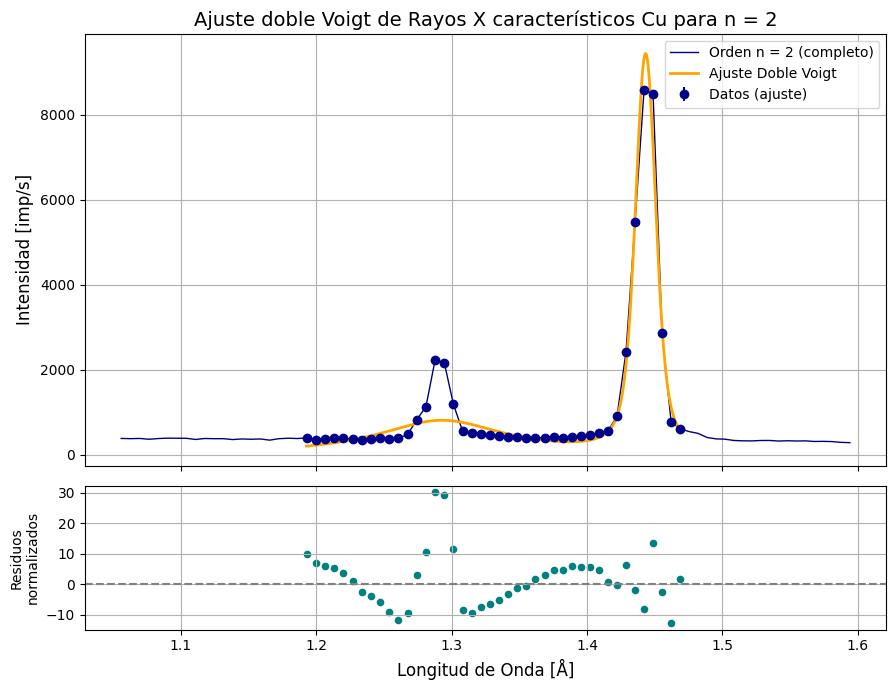

In [ ]:
# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# Ventana que cubre ambos picos
idx_fit = (lambda_b > 0.66) & (lambda_b < 0.8)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2]
p0 = [2000, 0.715, 0.005, 0.005, 9000, 0.785, 0.005, 0.005]

# Ajuste con pesos
popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=20000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_voigt(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_voigt(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Voigt')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt de Rayos X característicos Cu para n = 2', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()


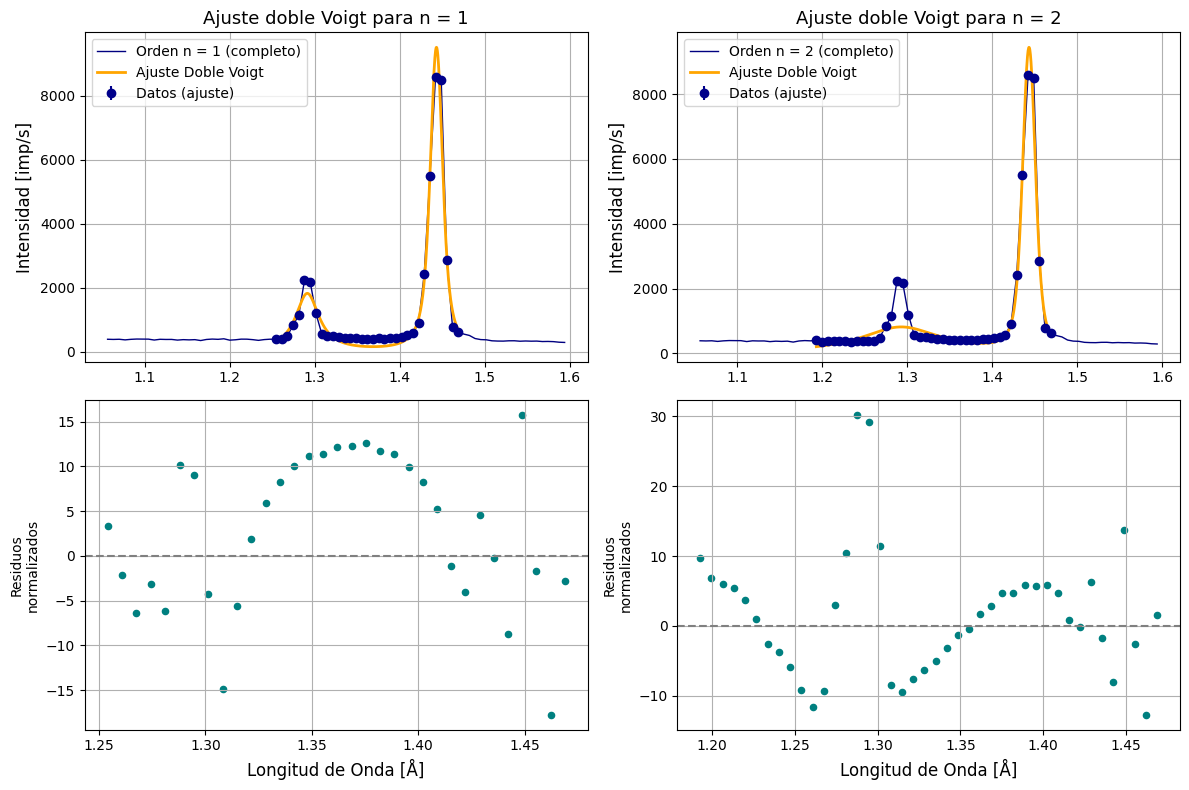

In [ ]:
# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# === INICIALIZAR FIGURA ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# ===== AJUSTE PARA n = 1 =====
idx_fit1 = (lambda_a > 1.25) & (lambda_a < 1.47)
x1 = lambda_a[idx_fit1]
y1 = intensity[idx_fit1]
errors1 = np.sqrt(y1)
errors1[errors1 == 0] = 1
p0_1 = [2000, 1.29, 0.005, 0.005, 9000, 1.43, 0.005, 0.005]
popt1, pcov1 = curve_fit(double_voigt, x1, y1, p0=p0_1, sigma=errors1, absolute_sigma=True, maxfev=20000)
x_fit1 = np.linspace(min(x1), max(x1), 800)
y_fit1 = double_voigt(x_fit1, *popt1)
res1 = (y1 - double_voigt(x1, *popt1)) / errors1

ax1 = axes[0, 0]
ax1r = axes[1, 0]

ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)
ax1.errorbar(x1, y1, yerr=errors1, fmt='o', color='darkblue', label='Datos (ajuste)')
ax1.plot(x_fit1, y_fit1, color='orange', linewidth=2, label='Ajuste Doble Voigt')
ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt para n = 1', fontsize=13)
ax1.legend()
ax1.grid(True)

ax1r.axhline(0, color='gray', linestyle='--')
ax1r.scatter(x1, res1, color='teal', s=20)
ax1r.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax1r.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax1r.grid(True)

# ===== AJUSTE PARA n = 2 =====
idx_fit2 = (lambda_b > 0.66) & (lambda_b < 0.8)
x2 = lambda_a[idx_fit2]
y2 = intensity[idx_fit2]
errors2 = np.sqrt(y2)
errors2[errors2 == 0] = 1
p0_2 = [2000, 0.715, 0.005, 0.005, 9000, 0.785, 0.005, 0.005]
popt2, pcov2 = curve_fit(double_voigt, x2, y2, p0=p0_2, sigma=errors2, absolute_sigma=True, maxfev=20000)
x_fit2 = np.linspace(min(x2), max(x2), 800)
y_fit2 = double_voigt(x_fit2, *popt2)
res2 = (y2 - double_voigt(x2, *popt2)) / errors2

ax2 = axes[0, 1]
ax2r = axes[1, 1]

ax2.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)
ax2.errorbar(x2, y2, yerr=errors2, fmt='o', color='darkblue', label='Datos (ajuste)')
ax2.plot(x_fit2, y_fit2, color='orange', linewidth=2, label='Ajuste Doble Voigt')
ax2.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax2.set_title('Ajuste doble Voigt para n = 2', fontsize=13)
ax2.legend()
ax2.grid(True)

ax2r.axhline(0, color='gray', linestyle='--')
ax2r.scatter(x2, res2, color='teal', s=20)
ax2r.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2r.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2r.grid(True)

plt.tight_layout()
plt.show()

Valores teóricos

Valores experimentales

In [ ]:
E_exp_a1 = h * c / (1.54 * 1e-9) #J
E_exp_b1 = h * c / (1.39221 * 1e-9) #J

E_exp_a2 = h * c / (0.7840 * 1e-9) #J
E_exp_b2 = h * c / (0.7077 * 1e-9) #J

print(E_exp_a1) 
print(E_exp_b1) 

print(E_exp_a2)
print(E_exp_b2) 

1.2907792207792207e-16
1.427801840239619e-16
2.5354591836734694e-16
2.8088172954641797e-16


**Actividad 2**

In [ ]:
def format_number(num, precision=2):
    if abs(num) < 1e-2 or abs(num) > 1e3: 
        return f'{num:.{precision}e}'
    else:  
        return f'{num:.{precision}f}'

d = 2.014e-10

Aldens = 2.7
Zndens = 7.14

NameB = np.array(['no barrera'])
NamesA = np.array(['al 0.02','al 0.04','al 0.08','al 0.1'])
NamesB = np.array(['zn 0.025','zn 0.05','zn 0.075','zn 0.1'])
thiknA = np.array([0.02, 0.04, 0.08, 0.1])
thiknB = np.array([0.025, 0.05, 0.075, 0.1])

PPath = ''

def Lineal_reg(x,A):
    return A*x

def lineal_regb(x,a,b):
    return a*x + b

def cuadratic_reg(x,a,b,c):
    return a*x**2 + b*x + c

def cub_reg(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x +d

def cuatro_reg(x,a,b,c,d,e):
    return a*x*4 + b*x**3 + c*x**2 + d*x + e

def cinco_reg(x,a,b,c,d,e,f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

def seis_reg(x,a,b,c,d,e,f,g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
 
def read_data(path, Names, thikn, skip_rows=3, BName = NameB):
    
    DataA = []
    
    with open(path + BName[0], 'r') as fileb:
        lines = islice(fileb, skip_rows, None)
        DataB = [list(map(float,line.replace(',', '.').split())) for line in lines]
    
    i = 0
    
    angles = {}
    
    while i < len(Names):
        CPath = path + Names[i]
        with open(CPath, 'r') as file:
            lines = islice(file, skip_rows, None)
            j = 0
            for line in lines:
                D = list(map(float,line.replace(',','.').split()))
                if not(str(D[0]) in angles):
                    angles[str(D[0])] = np.array([thikn[i], D[1]/DataB[j][1]]),    
                else:
                    angles[str(D[0])] = np.append(angles[str(D[0])],[[thikn[i], D[1]/DataB[j][1]]], axis=0)
                
                j += 1
        i += 1
    
    return angles

Datos1, Datos2 = read_data(PPath,NamesA,thiknA), read_data(PPath,NamesB,thiknB)

fig, axs = plt.subplots(2, 1, figsize=(15,7.5), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

fig.suptitle('Intensidad noralizada vs Espesor')

colores = np.array(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow'])
marcadores = np.array(['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h'])

j = 0

lambsAl = np.array([])
muAl = np.array([])
sigmuAl = np.array([])

for i in Datos1:
    
    lamb = 2*d*np.sin(np.radians(float(i)))*(10**9)
    lambsAl = np.append(lambsAl,float(lamb))
    lamb = format_number(lamb, 4)
    
    x = [Datos1[i][k][0] for k in range(len(Datos1[i]))]
    y = [np.log(Datos1[i][k][1]) for k in range(len(Datos1[i]))]
    
    param, cov = curve_fit(Lineal_reg, x, y)
    
    muAl = np.append(muAl, float(-param[0]))
    
    covn = np.sqrt(np.diagonal(cov))
    sigmuAl  = np.append(sigmuAl, float(covn[0]))
    covn = format_number(covn[0],0)
    
    _x = np.linspace(x[0],x[-1],200)
    _y = Lineal_reg(_x,param)
    
    res = (y - Lineal_reg(x, param))/np.std(y)
    
    param = format_number(-param[0], 0)
    
    axs[0].scatter(x,y, color=colores[j], marker = marcadores[j], label=f'{lamb:.4}nm ; '+r'$\mu = $' + f'{param} '+ r'$\pm$'+ f' {covn}')
    axs[0].set_ylabel('Intensidad normalizada ' + r'$\ln(\frac{I}{I_{0}})$')
    axs[0].legend(fontsize=7)
    axs[0].plot(_x,_y,color=colores[j])
    
    axs[1].scatter(x, res, color=colores[j], marker = marcadores[j])
    axs[1].axhline(0, color='black', linestyle='--')
    axs[1].set_xlabel('Espesor del material (mm)')
    axs[1].set_ylabel('Residuales\n normalizados')
    
    j += 1

for ax in axs:
    ax.grid(visible=True, linestyle="--", linewidth=0.7, alpha=0.7)
        
'''plt.savefig(r'Rayos_X\\Actividad2\\IntensidadEspesorAl.png', format='png', dpi=300)'''

plt.close()

fig, axs = plt.subplots(2, 1, figsize=(15,7.5), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

fig.suptitle('Intensidad noralizada vs Espesor')

j = 0

lambsZn = np.array([])
muZn = np.array([])
sigmuZn = np.array([])

for i in Datos2:
    
    lamb = 2*d*np.sin(np.radians(float(i)))*(10**9)
    lambsZn = np.append(lambsZn,float(lamb))
    lamb = format_number(lamb, 4)
    
    x = [Datos2[i][k][0] for k in range(len(Datos2[i]))]
    y = [np.log(Datos2[i][k][1]) for k in range(len(Datos2[i]))]
    
    param, cov = curve_fit(Lineal_reg, x, y)
    
    muZn = np.append(muZn, float(-param[0]))
    
    covn = np.sqrt(np.diagonal(cov))
    sigmuZn  = np.append(sigmuZn, float(covn[0]))
    covn = format_number(covn[0],0)
    
    _x = np.linspace(x[0],x[-1],200)
    _y = Lineal_reg(_x,param)
    
    res = (y - Lineal_reg(x, param))/np.std(y)
    
    param = format_number(-param[0], 0)
    
    axs[0].scatter(x,y, color=colores[j], marker = marcadores[j], label=f'{lamb:.4}nm ; '+r'$\mu = $' + f'{param} '+ r'$\pm$'+ f' {covn}')
    axs[0].set_ylabel('Intensidad normalizada ' + r'$\ln(\frac{I}{I_{0}})$')
    axs[0].legend(fontsize=7)
    axs[0].plot(_x,_y,color=colores[j])
    
    axs[1].scatter(x, res, color=colores[j], marker = marcadores[j])
    axs[1].axhline(0, color='black', linestyle='--')
    axs[1].set_xlabel('Espesor del material (mm)')
    axs[1].set_ylabel('Residuales\n normalizados')
    
    j += 1

for ax in axs:
    ax.grid(visible=True, linestyle="--", linewidth=0.7, alpha=0.7)
    
'''plt.savefig(r'Rayos_X\\Actividad2\\IntensidadEspesorZn.png', format='png', dpi=300)'''

plt.close()

muAlY = (muAl/Aldens)*10
muZnY = (muZn/Zndens)*10

lambAlX = lambsAl**3
lambZnX = lambsZn**3

sigmuAlN = (1/Aldens)*sigmuAl*10
sigmuZnN = (1/Zndens)*sigmuZn*10

fig, axs = plt.subplots(2, 1, figsize=(15,7.5), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

fig.suptitle('Coeficiente de absorción lineal vs longitud de onda')

axs[0].errorbar(lambAlX,muAlY, yerr = sigmuAlN, fmt='o', label='Datos Al', capsize = 3)
axs[0].errorbar(lambZnX,muZnY, yerr = sigmuZnN, fmt='o', label='Datos Zn', capsize = 3)
axs[0].set_ylabel(r"$\frac{\mu}{\rho} \quad \frac{\mathrm{cm}^{2}}{\mathrm{g}}$")

guess1 = [5.12e10,-1.13e5,37]
guess2 =[5.12e-6,-1.1912e-1,3.01e1,30]

param, cov  = curve_fit(cub_reg, lambAlX, muAlY, p0=guess2)
param2, cov2 = curve_fit(cub_reg, lambZnX, muZnY, p0=guess2)

_x = np.linspace(np.min(lambAlX), np.max(lambAlX),200)
_y = cub_reg(_x,*param)

_x2 = np.linspace(np.min(lambZnX), np.max(lambZnX),200)
_y2 = cub_reg(_x, *param2)

axs[0].plot(_x,_y, label='Ajuste cubico', color='red', linestyle='solid')
axs[0].plot(_x2,_y2, label='Ajuste cubico', color='red', linestyle='dashdot')
axs[0].legend()

res = (muAlY - cub_reg(lambAlX, *param))/sigmuAlN
res2 = (muZnY - cub_reg(lambZnX, *param2))/sigmuZnN

axs[1].scatter(lambAlX, res, color='black', marker = 'x', label='residuales Al')
axs[1].scatter(lambZnX, res2, color='black', marker = 'p', label='residuales Zn')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_xlabel('longitud de onda al cubo (nm^3)')
axs[1].set_ylabel('Residuales\n normalizados')

axs[1].legend()

for ax in axs:
    ax.grid(visible=True, linestyle="--", linewidth=0.7, alpha=0.7)


FileNotFoundError: [Errno 2] No such file or directory: 'Rayos_X\\no barrera'